In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')

# Load data
train_data = pd.read_csv('train_data.txt', sep=':::', engine='python', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
test_data = pd.read_csv('test_data.txt', sep=':::', engine='python', names=['ID', 'TITLE', 'DESCRIPTION'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# Data preprocessing class
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))

    def preprocess_text(self, text):
        if text is None:
            return ''
        # Lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize and remove stopwords
        tokens = text.split()
        tokens = [word for word in tokens if word not in self.stopwords]
        return ' '.join(tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.preprocess_text)

# Apply preprocessing
preprocessor = TextPreprocessor()
train_data['DESCRIPTION'] = preprocessor.fit_transform(train_data['DESCRIPTION'])
test_data['DESCRIPTION'] = preprocessor.transform(test_data['DESCRIPTION'])

# Extract features and labels
X_train = train_data['DESCRIPTION']
y_train = train_data['GENRE']
X_test = test_data['DESCRIPTION']
test_ids = test_data['ID']

# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:

# Function to create and train model, then return predictions and metrics
def train_and_evaluate_model(model, X_train_split, y_train_split, X_val_split, y_val_split, X_test, y_test=None):
    model.fit(X_train_split, y_train_split)

    # Validate the model
    y_val_pred = model.predict(X_val_split)
    val_accuracy = accuracy_score(y_val_split, y_val_pred)
    val_classification_report = classification_report(y_val_split, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val_split, y_val_pred)

    print(f"Validation Accuracy: {val_accuracy}")
    print("Validation Classification Report:\n", val_classification_report)

    # Predict on test data (regardless of y_test)
    y_test_pred = model.predict(X_test)

    # Return a placeholder for test_conf_matrix if y_test is not available
    test_conf_matrix = None # Placeholder when y_test is None

    # Calculate test metrics if y_test is available
    if y_test is not None:
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_classification_report = classification_report(y_test, y_test_pred)
        test_conf_matrix = confusion_matrix(y_test, y_test_pred)

        print(f"Test Accuracy: {test_accuracy}")
        print("Test Classification Report:\n", test_classification_report)

    # Always return 4 values
    return y_val_pred, y_test_pred, val_conf_matrix, test_conf_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_feature_importance(model, vectorizer, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.named_steps['logisticregression'].coef_.flatten()
    # Ensure indices are within valid range
    top_positive_features = np.argsort(coefficients)[-top_n // 2:]
    top_negative_features = np.argsort(coefficients)[:top_n // 2]
    top_features = np.concatenate([top_negative_features, top_positive_features])
    top_features = top_features[top_features < len(feature_names)] # Ensure valid indices

    plt.figure(figsize=(10, 7))
    plt.barh(np.array(feature_names)[top_features], coefficients[top_features], color='blue')
    plt.xlabel('Coefficient Value')
    plt.title('Top Feature Importance')
    plt.show()

# Function to plot genre counts
def plot_genre_counts(predicted_genres, model_name):
    genre_counts = Counter(predicted_genres)
    genres = list(genre_counts.keys())
    counts = list(genre_counts.values())

    plt.figure(figsize=(30, 6))
    plt.bar(genres, counts, color='skyblue')
    plt.title(f'Predicted Genre Counts - {model_name}')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()



--- Logistic Regression ---


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 0.5786221525408097
Validation Classification Report:
                precision    recall  f1-score   support

      action        0.57      0.22      0.31       263
       adult        0.86      0.17      0.28       112
   adventure        0.45      0.11      0.17       139
   animation        0.50      0.01      0.02       104
   biography        0.00      0.00      0.00        61
      comedy        0.52      0.58      0.55      1443
       crime        1.00      0.01      0.02       107
 documentary        0.65      0.87      0.74      2659
       drama        0.53      0.81      0.64      2697
      family        0.53      0.05      0.10       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.92      0.30      0.45        40
     history        0.00      0.00      0.00        45
      horror        0.67      0.55      0.61       431
       music        0.67      0.39      0.49       144
     musical        0.00      0.00      0.00

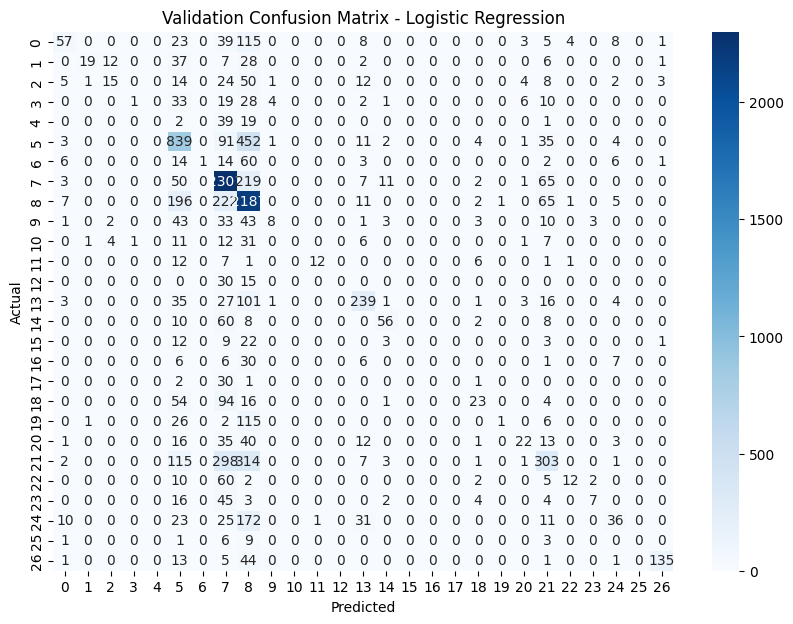

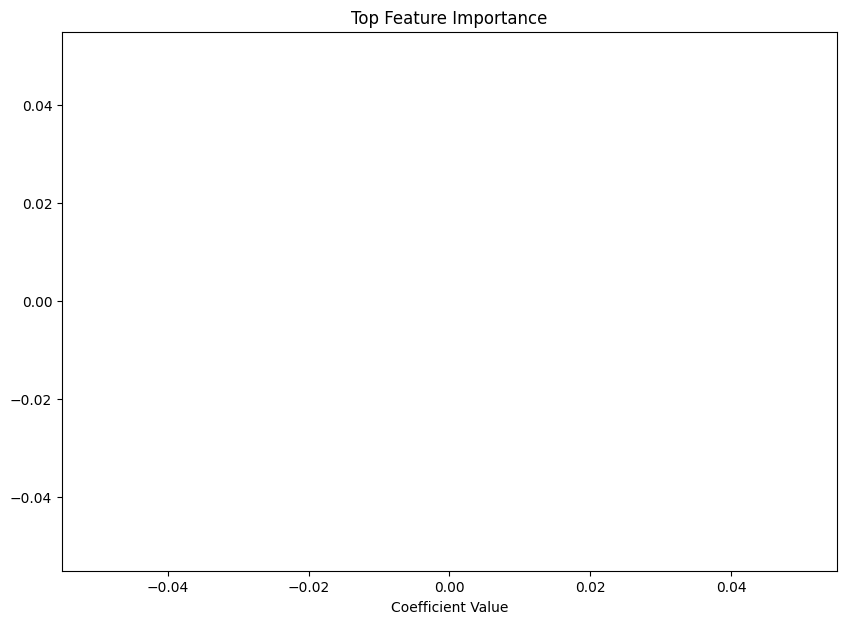

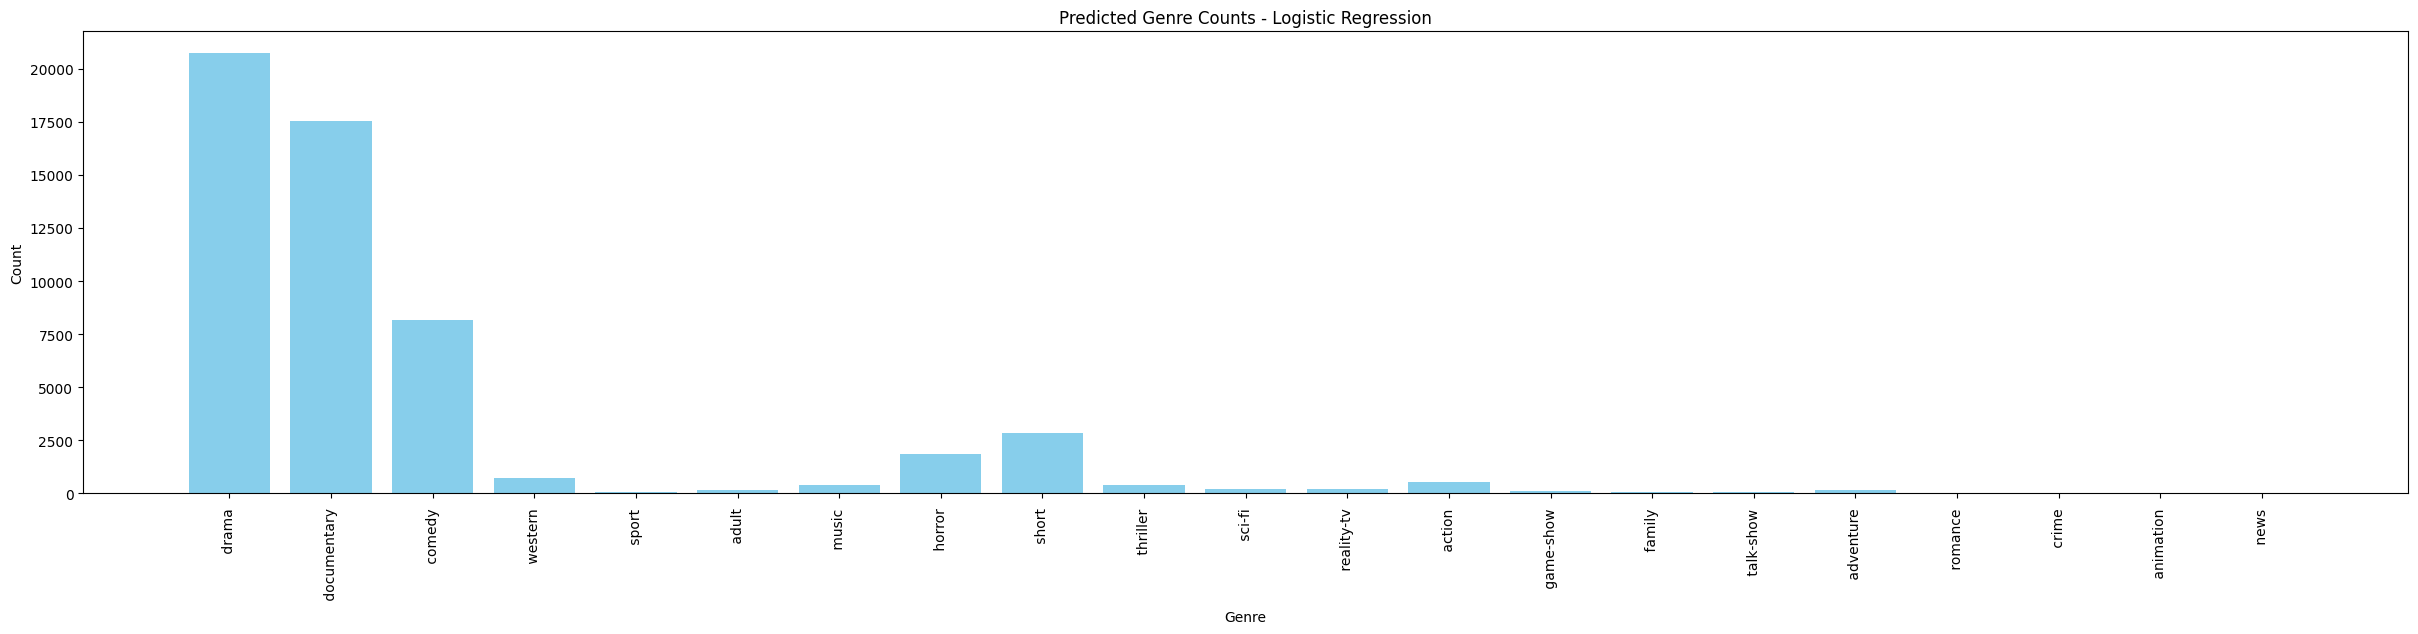


--- Naive Bayes ---


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 0.4461864797565249
Validation Classification Report:
                precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.71      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00

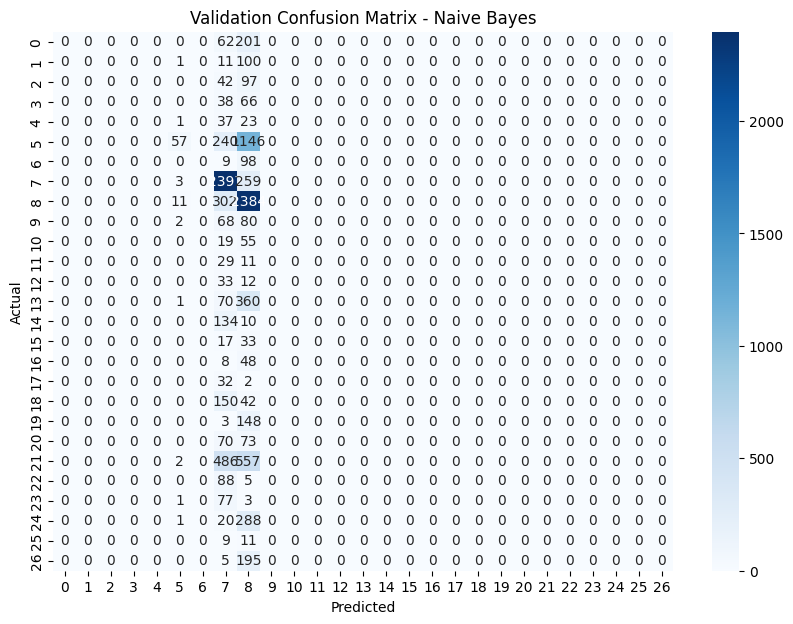

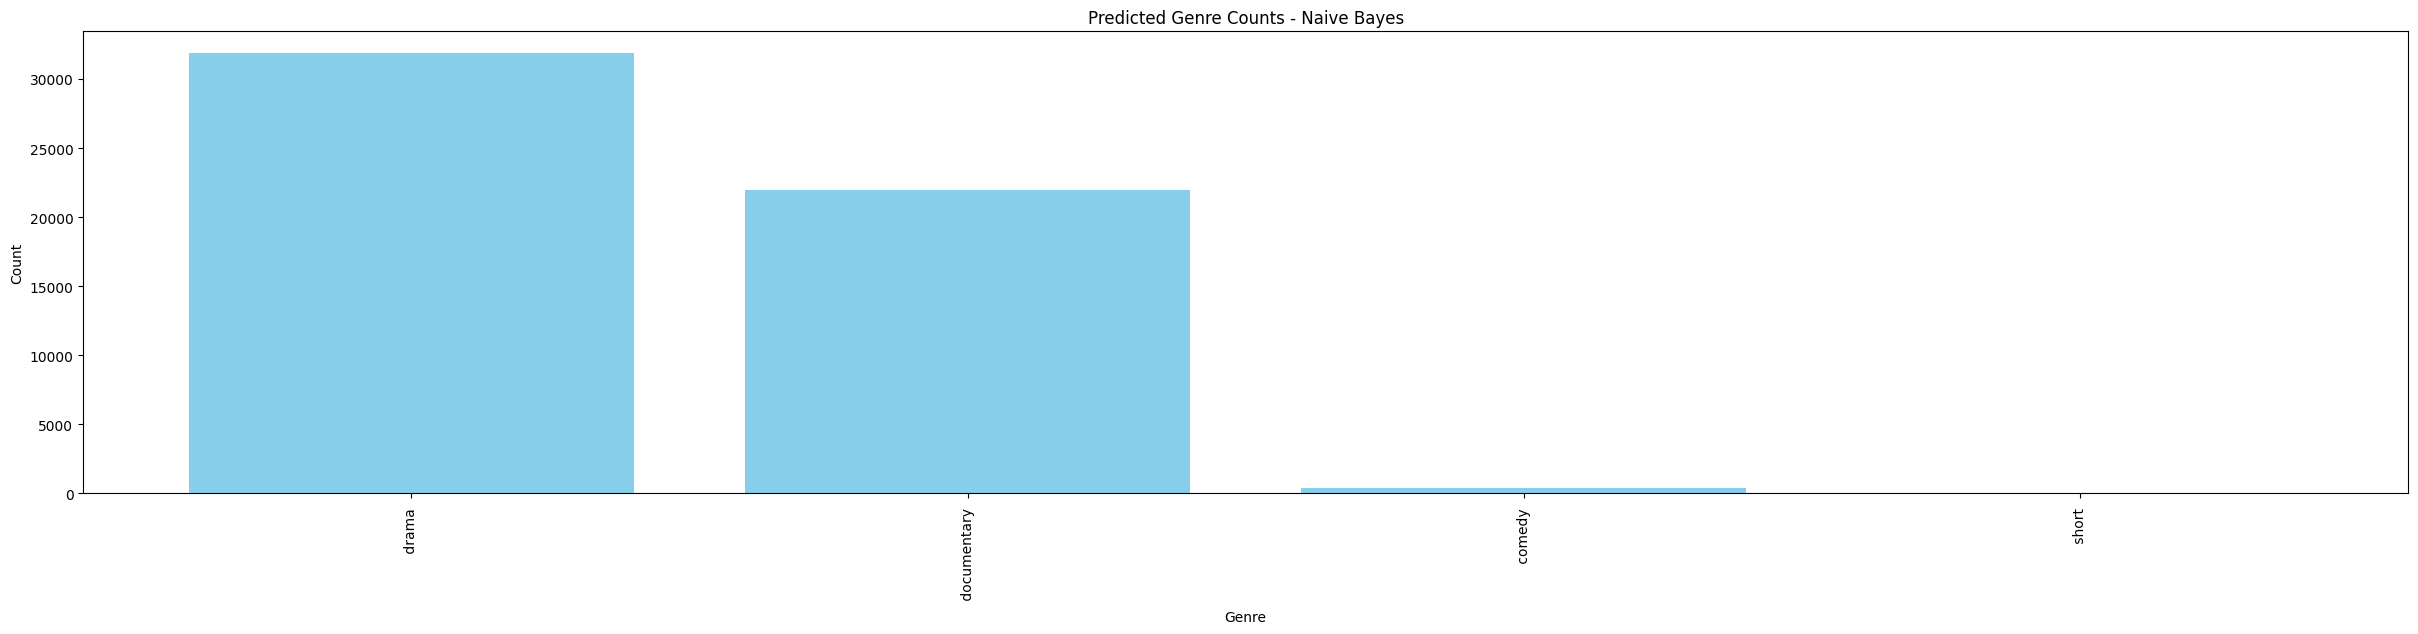

In [ ]:
# Create and evaluate models
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB()

}

trained_models = {}

for name, classifier in classifiers.items():
    print(f"\n--- {name} ---")
    model = make_pipeline(TfidfVectorizer(), classifier)
    y_val_pred, y_test_pred, val_conf_matrix, test_conf_matrix = train_and_evaluate_model(model, X_train_split, y_train_split, X_val_split, y_val_split, X_test)

    plot_confusion_matrix(val_conf_matrix, f'Validation Confusion Matrix - {name}')
    if name == "Logistic Regression":
        # Plot feature importance only for Logistic Regression
        vectorizer = model.named_steps['tfidfvectorizer']
        plot_feature_importance(model, vectorizer)

    # Store the trained model
    trained_models[name] = model

    # Save validation set predictions to a CSV file
    val_predictions_df = pd.DataFrame({
        'ID': X_val_split.index,
        'Predicted_Genre': y_val_pred
    })
    val_predictions_df.to_csv(f'validation_predictions_{name.replace(" ", "_").lower()}.csv', index=False)

    # Save test set predictions to a CSV file (if available)
    if y_test_pred is not None:
        test_predictions_df = pd.DataFrame({
            'ID': test_ids,
            'Predicted_Genre': y_test_pred
        })
        test_predictions_df.to_csv(f'test_predictions_{name.replace(" ", "_").lower()}.csv', index=False)

        # Plot genre counts for test set predictions
        plot_genre_counts(y_test_pred, name)


In [ ]:


# Function to predict genre for a user-provided movie description
def predict_genre(description, model):
    description = preprocessor.preprocess_text(description)  # Preprocess the user input
    prediction = model.predict([description])
    return prediction[0]

# Print descriptions, true genres, and predicted genres
def print_predictions(X, y_true, y_pred, n=30):
    for i in range(min(n, len(y_true))):
        print(f'Description: {X.iloc[i]}')
        print(f'True Genre: {y_true.iloc[i]}')
        print(f'Predicted Genre: {y_pred[i]}')
        print('---')

# Assuming you have true genres for test data (Y_test)
# Otherwise, you can comment out the following line if Y_test is not available
# print_predictions(X_test, Y_test, y_test_pred, 30)

# If you want to print predictions for validation set
print_predictions(X_val_split, y_val_split, y_val_pred, 30)


Description: catherine stjohnburke independent uptight status obsessed sophisticated british woman living alone londons chelsea favors affair married man world turned upside comes home one day discover uneducated kiwi woman hairy legs drinking beer living room shirley zachary claims catherines long lost halfsister father catherine thought died child still alive trying make claims properties following death mothers furious frustrated shirleys refusal disappear shirley reluctantly agrees undertake dna test catherines horror results concludes indeed related girls agree work together track conman trapped father order get rightful ownership inheritance course hiding local mob jack easy man find begin following man called sir crawford hilarious consequences
True Genre:  comedy 
Predicted Genre:  drama 
---
Description: beginning century train young woman comes paris nurse front young man also wants join capital mason soon lady complains discomfort pain given breast since yesterday finally ma